In [110]:
# Common imports
import numpy as np
import numpy.random as rnd
import os
import sys
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, optimize_loss
import matplotlib.pyplot as plt
from scipy import misc
import math

# set parameters
p = 0.4 # the size of the encoding is p * target_width * target_height
read_dir = 'cats_and_dogs/'
batch_size = 100
target_width = 40
target_height = 40
n_samples = 12500
max_learning_rate = 0.001
min_learning_rate = 0.000001
n_batches = n_samples // batch_size


decay_speed = math.pow( (min_learning_rate / (max_learning_rate - min_learning_rate)) , 1 / ( n_epochs * n_batches) )

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [111]:
# Loading the image sets

class data_feeder():
    def __init__(self,read_dir, target_width=100, target_height=100):
        self.read_dir = read_dir
        self.current_idx = 0
        self.w = target_width
        self.h = target_height

    def next_batch(self, batch_size):
        ret_list = list()
        #print(self.current_idx)
        for i in range(self.current_idx, self.current_idx + batch_size):
            pic = misc.imread(self.read_dir + 'cat.' + str(i) + '.jpg', flatten=True)
            #print(pic.shape)
            resized = misc.imresize(pic, (self.h, self.w))/256
            vectorized = resized.reshape((target_height*target_width,))
            ret_list.append(vectorized)
            self.current_idx += 1
            if self.current_idx >= n_samples:
                self.current_idx = 0
                break
        #print(self.current_idx)
        return np.asarray(ret_list, dtype='f')

catdog = data_feeder(read_dir, target_width, target_height)
first_batch = catdog.next_batch(100)
#print(first_batch.shape)
#print(first_batch)
second_batch = catdog.next_batch(100)
#print(second_batch.shape)
#print(second_batch)


In [112]:
# Useful Plotting Functions
def save_fig(fig_id, tight_layout=True):
    path = os.path.join("images/", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image, shape=[target_height, target_width]):
    plt.imshow(image.reshape(shape), cmap='Greys',interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap='Greys', interpolation="nearest")
    plt.axis("off")

In [113]:
# STANDARD AUTOENCODER
tf.reset_default_graph()

n_inputs = target_width * target_height # x pixels by y pixels
n_hidden1 = 1000
n_hidden2 = (int) (p * n_inputs)  # codings will be p% the size of the original image
n_hidden3 = n_hidden1
n_hidden4 = n_inputs


initializer = tf.contrib.layers.variance_scaling_initializer()

weights1_initializer = initializer([n_inputs, n_hidden1])
weights2_initializer = initializer([n_hidden1, n_hidden2])


X = tf.placeholder(tf.float32, [None, n_inputs])
global_step1 = tf.Variable(0, trainable=False)
lr1 = tf.train.exponential_decay(max_learning_rate, global_step1, n_batches, decay_speed)

# It was necessary to build these layers by hand because 
# I wanted to tie the weights of layers 1 & 2 to the weights
# of layers 3 & 4.
w1 = tf.Variable(weights1_initializer, dtype=tf.float32)
w2 = tf.Variable(weights2_initializer, dtype=tf.float32)
w3 = tf.transpose(w2)
w4 = tf.transpose(w1)

b1 = tf.Variable(tf.zeros(n_hidden1))
b2 = tf.Variable(tf.zeros(n_hidden2))
b3 = tf.Variable(tf.zeros(n_hidden3))
b4 = tf.Variable(tf.zeros(n_inputs))



In [114]:
# VARIATIONAL AUTOENCODER
n_inputs2 = n_hidden2 
n_hiddena = 500
n_hiddenb = 500
n_hiddenc = 20
n_hiddend = n_hiddenb
n_hiddene = n_hiddena
n_outputs = n_inputs2

global_step2 = tf.Variable(0, trainable=False)
lr2 = tf.train.exponential_decay(max_learning_rate, global_step2, n_batches, decay_speed)
initializer = tf.contrib.layers.variance_scaling_initializer(factor=0.00001)

with tf.contrib.framework.arg_scope([fully_connected],
                                    activation_fn=tf.nn.elu,
                                    weights_initializer=initializer):
    
    hidden1 = tf.nn.elu(tf.matmul(X, w1) + b1)
    hidden2 = tf.nn.elu(tf.matmul(hidden1, w2) + b2)
    
    # Inner model uses tf.contrib.layers
    hiddena = fully_connected(hidden2, n_hiddena, scope="VAE/a")
    hiddenb = fully_connected(hiddena, n_hiddenb, scope="VAE/b")
    hiddenc_mean = fully_connected(hiddenb, n_hiddenc, activation_fn=None, scope="VAE/cm")
    hiddenc_gamma = fully_connected(hiddenb, n_hiddenc, activation_fn=None, scope="VAE/cg")
    noise = tf.random_normal(tf.shape(hiddenc_gamma), dtype=tf.float32)
    hiddenc = hiddenc_mean + tf.exp(0.5 * hiddenc_gamma) * noise
    hiddend = fully_connected(hiddenc, n_hiddend, scope="VAE/d")
    hiddene = fully_connected(hiddend, n_hiddene, scope="VAE/e")
    logits = fully_connected(hiddene, n_outputs, activation_fn=None, scope="VAE/f")
    hiddenf = tf.nn.elu(logits)
    
    hidden3 = tf.nn.elu(tf.matmul(hiddenf, w3) + b3)
    outputs = tf.sigmoid(tf.matmul(hidden3, w4) + b4)




In [115]:
with tf.name_scope("standard_autoencoder"):
    optimizer = tf.train.AdamOptimizer(lr1)
    p1_hidden2 = tf.nn.elu(tf.matmul(hidden1, w2) + b2)
    p1_hidden3 = tf.nn.elu(tf.matmul(p1_hidden2, w3) + b3)
    
    phase1_outputs = tf.matmul(p1_hidden3, w4) + b4
    phase1_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    external_ae_var = [w1,w2,b1,b2,b3,b4]
    phase1_training_op = optimizer.minimize(phase1_loss, global_step=global_step1, var_list=external_ae_var)

with tf.name_scope("internal_VAE"):
    reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=hidden2, logits=logits))
    latent_loss = 0.5 * tf.reduce_sum(tf.exp(hiddenc_gamma) + tf.square(hiddenc_mean) - 1 - hiddenc_gamma)
    phase2_loss = tf.reduce_mean(tf.square(hiddenf - hidden2))#reconstruction_loss + latent_loss
    internal_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "VAE")
    phase2_training_op = optimize_loss(phase2_loss, optimizer='Adam', learning_rate=lr2, global_step=global_step2,
                                            variables=internal_vars) 

In [116]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
training_ops = [phase1_training_op, phase2_training_op]
losses = [phase1_loss, phase2_loss]
n_epochs = [100, 100]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print('Training Phase {}'.format(phase + 1))
        
        for epoch in range(n_epochs[phase]):
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch = catdog.next_batch(batch_size)
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = sess.run(losses[phase], feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Training Loss:", loss_train)
            saver.save(sess, "./my_cat_model.ckpt")

Training Phase 1
0 Training Loss: 0.0287444
1 Training Loss: 0.0201558
2 Training Loss: 0.0153723
3 Training Loss: 0.0125572
4 Training Loss: 0.0106975
5 Training Loss: 0.00931885
6 Training Loss: 0.00870212
7 Training Loss: 0.00752792
8 Training Loss: 0.0068621
9 Training Loss: 0.00633458
10 Training Loss: 0.00588982
11 Training Loss: 0.00540362
12 Training Loss: 0.00504082
13 Training Loss: 0.00482885
14 Training Loss: 0.00461882
15 Training Loss: 0.00448516
16 Training Loss: 0.00415429
17 Training Loss: 0.0047472
18 Training Loss: 0.00478177
19 Training Loss: 0.00402611
20 Training Loss: 0.00377811
21 Training Loss: 0.0037304
22 Training Loss: 0.00373376
23 Training Loss: 0.00372473
24 Training Loss: 0.00358487
25 Training Loss: 0.00377176
26 Training Loss: 0.00337638
27 Training Loss: 0.0030947
28 Training Loss: 0.00470701
29 Training Loss: 0.00419093
30 Training Loss: 0.00357211
31 Training Loss: 0.00284491
32 Training Loss: 0.00325769
33 Training Loss: 0.00301437
34 Training Loss

In [123]:

n_digits = 10
X_test = catdog.next_batch(batch_size)
codings = hiddenc

with tf.Session() as sess:
    saver.restore(sess, "./my_cat_model.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

In [124]:
with tf.Session() as sess:
    saver.restore(sess, "./my_cat_model.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

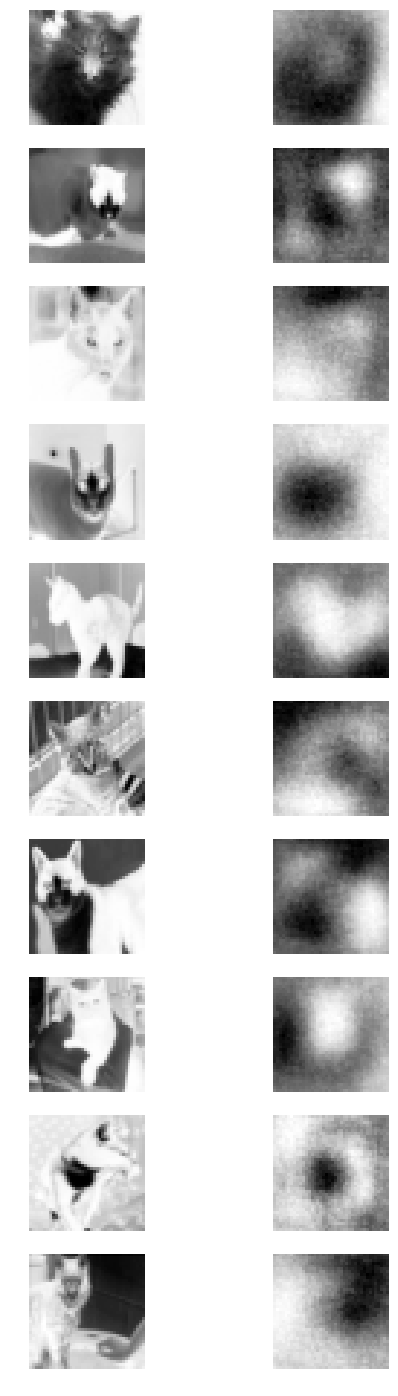

In [125]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

In [126]:
n_rows = 6
n_cols = 10
n_digits = n_rows * n_cols
codings_rnd = np.random.normal(size=[n_digits, n_hiddenc])

with tf.Session() as sess:
    saver.restore(sess, "./my_cat_model.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_rnd})

Saving figure generated_cat_pics


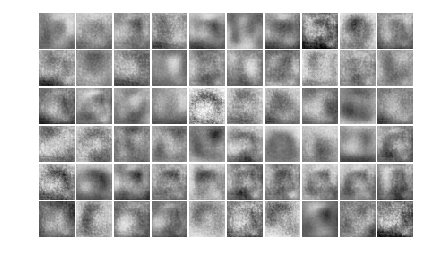

In [127]:
plot_multiple_images(outputs_val.reshape(-1, target_height, target_width), n_rows, n_cols)
save_fig("generated_cat_pics")
plt.show()